<a href="https://colab.research.google.com/github/pswietojanski/BeamformIt/blob/master/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import gspread
import csv
from oauth2client.service_account import ServiceAccountCredentials
from google.colab import drive

In [2]:
#do not run, unless something fails!
!pip install bokeh==2.1.1
!pip install -U ipykernel

Requirement already up-to-date: ipykernel in /usr/local/lib/python3.6/dist-packages (5.3.0)


In [ ]:
!git clone https://github.com/pswietojanski/ojsp_adaptation_review_2020.git

fatal: destination path 'ojsp_adaptation_review_2020' already exists and is not an empty directory.


#Data IO


In [114]:
def load_df_csv(fname):
    with open(fname, 'r') as f:
        data = pd.read_csv(f)
        return data

def load_from_csv():
    f1 = 'ojsp-meta-analysis - meta.csv'
    f2 = 'ojsp-meta-analysis - method2level.csv'
    f3 = 'ojsp-meta-analysis - defs.csv'
    df1 = load_df_csv(f1)
    df2 = load_df_csv(f2)
    df3 = load_df_csv(f3)
    return df1, df2, df3

def load_df_gsheet():
    scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']
    credentials = ServiceAccountCredentials.from_json_keyfile_name(
         '/content/ojsp_adaptation_review_2020/ojsp-sa-1592840444343-783932c34af3.json', scope)
    gc = gspread.authorize(credentials)
    ws = gc.open("ojsp-meta-analysis")
    meta = ws.worksheet("meta")
    method2level = ws.worksheet("method2level")
    defs = ws.worksheet("defs")
    return (pd.DataFrame(meta.get_all_records()), 
            pd.DataFrame(method2level.get_all_records()),
            pd.DataFrame(defs.get_all_records())) 

def filter_data(data):
    #remove entries with empty WERs
    s1 = data.shape
    data['WERR'].replace('', np.nan, inplace=True)
    data = data.dropna(subset=['WERR'])
    s2 = data.shape
    print (f"Before {s1} / {s2} after filtering on empty WERR")
    #remove entries explicitly annotated to not use in aggregation
    s1 = data.shape
    data = data[data['use_in_agg'] == 'yes']
    s2 = data.shape
    print (f"Before {s1} / {s2} after filtering on use in aggregation")
    return data

def check(df, defs):
    raise NotImplementedError()

def annotate_method2level(df, df_m2l, field='Method1'):
    m2l = dict(zip(df_m2l.method, df_m2l.level))
    colname = f'{field}Level'
    df.insert(loc=1, column=colname, value='')
    for idx, row in df.iterrows():
        m = df.loc[idx, field]
        assert m in m2l,(
            f"Key {m} not found in m2l"
        )
        df.loc[idx, colname] = m2l[m]
    return df


#Pre-load Gsheet

In [115]:
method, method2level, defs = load_df_gsheet()
df = filter_data(method)
df = annotate_method2level(df, method2level)

Before (136, 24) / (132, 24) after filtering on empty WERR
Before (132, 24) / (131, 24) after filtering on use in aggregation


#Analysis functions

In [69]:
def low_perc(x):
  return np.percentile(x, 25.)

def high_perc(x):
  return np.percentile(x, 75.)

def aggregate_stats(data, fields):
    g1 = data.groupby(fields)
    return g1, g1.agg(
           werr=pd.NamedAgg(column='WERR', aggfunc='mean'),
           werr_std=pd.NamedAgg(column='WERR', aggfunc='std'),
           min=pd.NamedAgg(column='WERR', aggfunc='min'),
           max=pd.NamedAgg(column='WERR', aggfunc='max'),
           median=pd.NamedAgg(column='WERR', aggfunc='median'),
           low_perc=pd.NamedAgg(column='WERR', aggfunc=low_perc),
           high_perc=pd.NamedAgg(column='WERR', aggfunc=high_perc),
           n_points=pd.NamedAgg(column='WERR', aggfunc='count'),
           n_studies=pd.NamedAgg(column='BibentryId', aggfunc='nunique'),
           n_dsets=pd.NamedAgg(column='Train', aggfunc='nunique'))

def plot_boxplot_from_stats(stats, vert=False):
    cols = stats.columns.tolist()
    assert 'low_perc' in cols, (
        'Wrong stats, use aggregate_stats to obtain these'
    )
    stats.transpose().loc[['min', 'max', 'median', 'low_perc', 'high_perc'], :].plot.box(grid=True, vert=vert, figsize=(8,8))



# Top-level aggregation by adaptation method

In [117]:
#Filter out all datapoints that use more than one aux adaptation technique (first we want to see how each behaves as a standalone)
df_1method = df[(df.Method2 == '') & (df.Method3 == '')]
#also filter non-speaker adaptation clusters (domain, accent). For now, these seem to bias stuff 
# (perhaps later, when we have proper sizes of adaptation transforms, etc. we can capture this better).
df_1method = df_1method[df_1method.adapt_to.isin(['speaker', 'utterance'])]

               werr   werr_std        min        max     median   low_perc  high_perc  n_points  n_studies  n_dsets
Method1                                                                                                            
CFA       12.123249  10.792708   4.000000  24.369748   8.000000   6.000000  16.184874         3          2        2
CMN        4.593640        NaN   4.593640   4.593640   4.593640   4.593640   4.593640         1          1        1
CNNEmb    -2.631582  13.207147 -24.725275   7.506427  -0.274725  -3.084833   7.420495         5          2        2
DNNEmb    -4.683183  10.826888 -20.329670   3.393316  -0.898189  -7.665965   2.084593         4          1        1
Finetune  14.082804  10.453110   1.200000  46.900000  11.851852   5.800000  19.491525        25          7        5
LHT       15.536105   5.570207  11.597374  19.474836  15.536105  13.566740  17.505470         2          1        1
LHUC       9.672782   5.291356   2.389706  18.181818   8.487085   6.4516

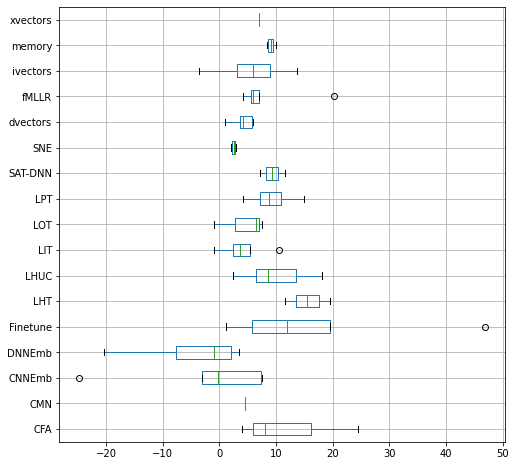

In [118]:
#first further remove all datapoints generated with other adaptation techniques
g1, agg = aggregate_stats(df_1method, ['Method1'])
print (agg.to_string())
plot_boxplot_from_stats(agg)

#sat vs test-only (technique level)

                   werr   werr_std        min        max     median   low_perc  high_perc  n_points  n_studies  n_dsets
Method1  sat                                                                                                           
CFA      no    6.000000   2.828427   4.000000   8.000000   6.000000   5.000000   7.000000         2          1        1
         yes  24.369748        NaN  24.369748  24.369748  24.369748  24.369748  24.369748         1          1        1
CMN      yes   4.593640        NaN   4.593640   4.593640   4.593640   4.593640   4.593640         1          1        1
CNNEmb   no   -5.144602  13.801082 -24.725275   7.506427  -1.679779  -8.494943   1.670563         4          1        1
         yes   7.420495        NaN   7.420495   7.420495   7.420495   7.420495   7.420495         1          1        1
DNNEmb   no   -4.683183  10.826888 -20.329670   3.393316  -0.898189  -7.665965   2.084593         4          1        1
Finetune no   14.082804  10.453110   1.2

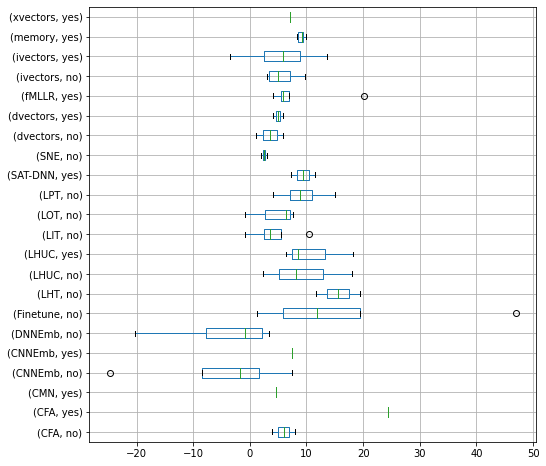

In [88]:
#sat vs. non sat (if techniques support it)
g_sat, agg_sat = aggregate_stats(df_1method, ['Method1', 'sat'])
print (agg_sat.to_string())
plot_boxplot_from_stats(agg_sat)

#sat vs. test-only top level

         werr   werr_std        min        max    median  low_perc  high_perc  n_points  n_studies  n_dsets
sat                                                                                                        
no   8.258164  10.062328 -24.725275  46.900000  7.506427  3.514706  12.713256        67         15       13
yes  8.090504   5.685903  -3.571429  24.369748  7.301408  5.574275   9.355294        30          8        6


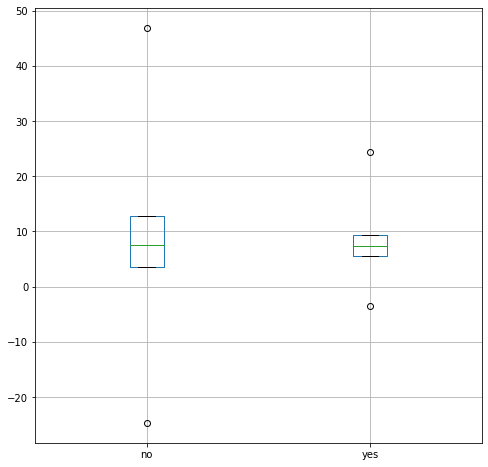

In [90]:
#sat vs. non sat globally
g_sat2, agg_sat2 = aggregate_stats(df_1method, ['sat'])
print (agg_sat2.to_string())
plot_boxplot_from_stats(agg_sat2, vert=True)

#hybrid vs. e2e

                  werr  werr_std        min        max     median   low_perc  high_perc  n_points  n_studies  n_dsets
System                                                                                                               
E2E-AED      13.014286  9.918069   2.100000  29.500000  11.200000   5.950000  18.200000         7          2        2
E2E-AED-CTC   2.510101  0.692822   2.020202   3.000000   2.510101   2.265152   2.755051         2          1        1
E2E-CTC       6.275000  3.898183   1.200000  10.500000   6.700000   4.650000   8.325000         4          1        1
E2E-RNN-T    46.900000       NaN  46.900000  46.900000  46.900000  46.900000  46.900000         1          1        1
Hybrid        7.180147  7.645090 -24.725275  24.369748   7.067138   4.000000  10.526316        81         13       12
hybrid       23.150000  6.151829  18.800000  27.500000  23.150000  20.975000  25.325000         2          1        1


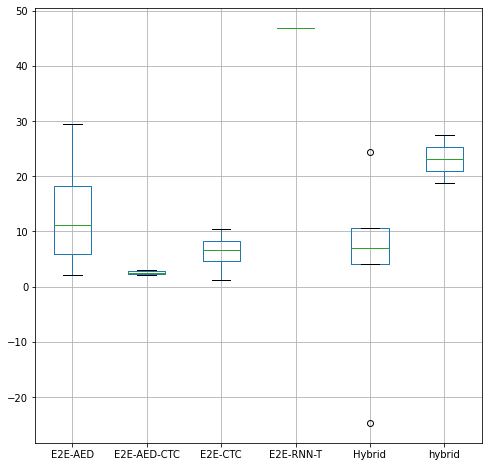

In [84]:
#hybrid vs. e2e
#TODO: check why E2E-RNN-T is so high
g_sys, agg_sys = aggregate_stats(df_1method, ['System'])
print (agg_sys.to_string())
plot_boxplot_from_stats(agg_sys, vert=True)

#embedding vs. features vd. model

                   werr  werr_std        min        max    median  low_perc  high_perc  n_points  n_studies  n_dsets
Method1Level                                                                                                        
embedding      3.701658  7.698702 -24.725275  13.664596  5.797101  2.020202   8.480565        37          8        6
feature        6.403066  5.631801  -0.925926  20.168067  5.046820  3.824443   6.654920        10          6        6
model         11.900402  8.731667  -0.925926  46.900000  9.046214  5.958187  16.703461        50         11       12


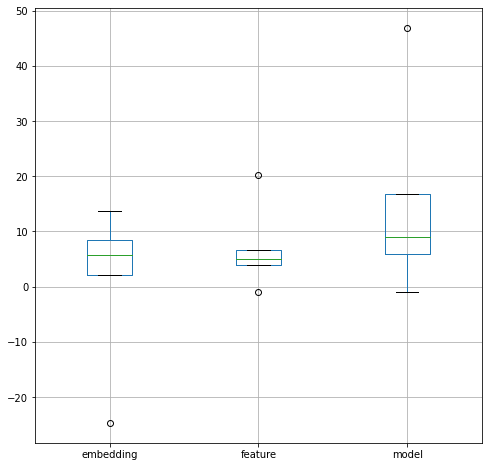

In [120]:
g_lvl, agg_lvl = aggregate_stats(df_1method, ['Method1Level'])
print (agg_lvl.to_string())
plot_boxplot_from_stats(agg_lvl, vert=True)

#supervised vs. unsupervised (yes below means unsupervised)

            werr   werr_std        min        max     median   low_perc  high_perc  n_points  n_studies  n_dsets
Unsup                                                                                                           
no     10.928608  11.939741   2.020202  46.900000   7.600000   4.000000  11.200000        13          7        6
semi   22.440000   6.226395  14.300000  29.500000  22.100000  18.800000  27.500000         5          1        1
yes     6.857471   7.597102 -24.725275  24.369748   6.912442   3.585373   9.823151        79         15       12


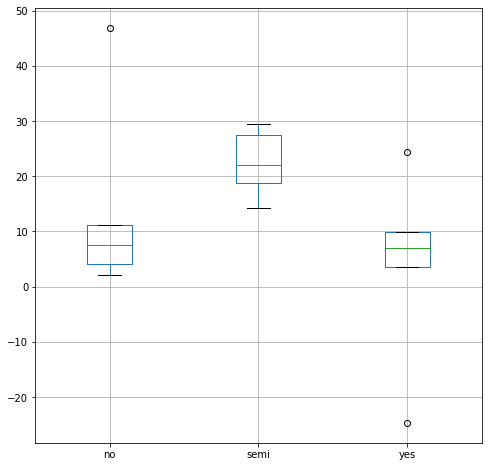

In [122]:
g_sup, agg_sup = aggregate_stats(df_1method, ['Unsup'])
print (agg_sup.to_string())
plot_boxplot_from_stats(agg_sup, vert=True)

# adapt mode 


                 werr  werr_std        min        max    median  low_perc  high_perc  n_points  n_studies  n_dsets
Adapt mode                                                                                                        
2pass        9.186230  5.814462   2.389706  24.369748  7.622888  4.905497  10.650586        26          4        6
enrol       11.661365  9.367185  -0.925926  46.900000  9.046214  4.970967  15.640797        40          8        6
online       2.926307  8.137878 -24.725275  13.664596  3.629389  1.342242   7.463461        31          6        5


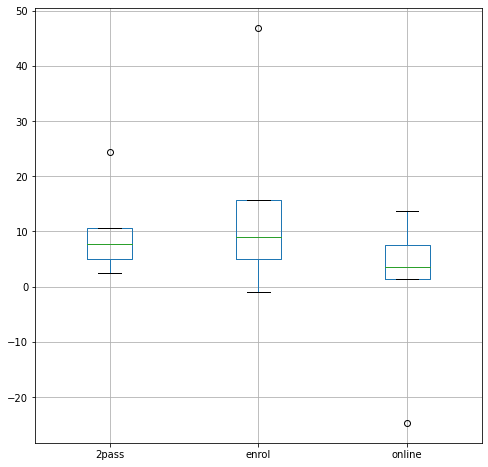

In [123]:
g_mode, agg_mode = aggregate_stats(df_1method, ['Adapt mode'])
print (agg_mode.to_string())
plot_boxplot_from_stats(agg_mode, vert=True)

#type of AM (FF, RNN) then archs (CNN, DNN, etc.)


         werr  werr_std        min   max   median  low_perc  high_perc  n_points  n_studies  n_dsets
AM                                                                                                  
FF   7.591140  8.712697 -24.725275  27.5  6.98979  3.604281  11.903073        68         13       12
RNN  9.648779  9.351373   1.200000  46.9  7.95000  4.000000   9.929078        29          9        8


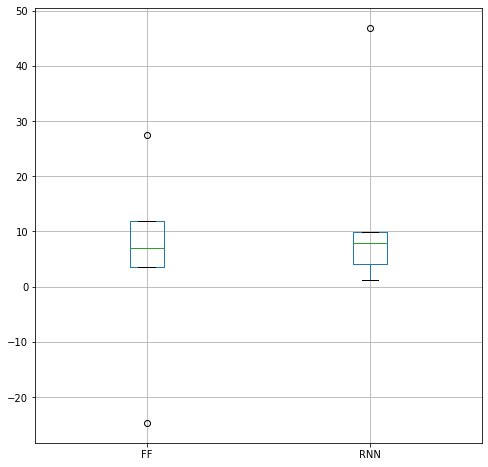

In [126]:
g_am, agg_am = aggregate_stats(df_1method, ['AM'])
print (agg_am.to_string())
plot_boxplot_from_stats(agg_am, vert=True)

            werr   werr_std        min        max    median  low_perc  high_perc  n_points  n_studies  n_dsets
arch                                                                                                          
BLSTM   6.904923   2.469719   4.000000   9.929078  7.975000  4.075000   8.365076         8          2        2
CNN     7.515667   4.181321   2.389706  18.103448  7.182320  4.981884   8.507108        11          3        6
DNN    10.334801   7.009572  -0.925926  27.500000  8.500000  4.629630  15.204678        45         11       10
LSTM   11.596102  11.417208   1.200000  46.900000  8.477286  4.075000  13.525000        18          6        5
LSTMP   5.281794   1.441935   3.629389   6.285040  5.930953  4.780171   6.107996         3          1        1
TDNN   -2.628405  10.256844 -24.725275   9.717224 -1.098901 -3.476405   3.431877        12          1        1


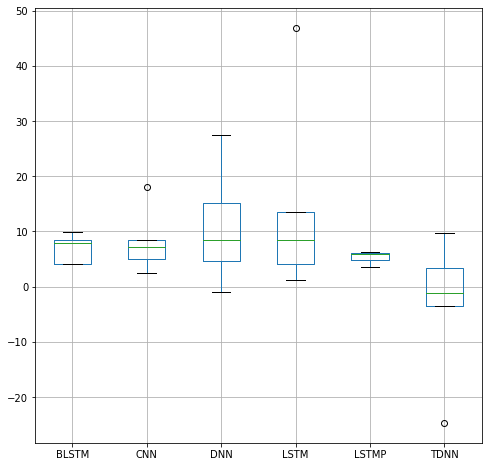

In [127]:
g_am, agg_am = aggregate_stats(df_1method, ['arch'])
print (agg_am.to_string())
plot_boxplot_from_stats(agg_am, vert=True)

#adapt to speaker, accent, domain, utterance, etc.

                werr   werr_std        min        max     median   low_perc  high_perc  n_points  n_studies  n_dsets
adapt_to                                                                                                            
accent     15.882725   2.775022  12.737030  19.500846  15.646512  14.883721  16.645516         4          1        1
domain     33.133333  10.167137  20.100000  45.500000  34.050000  25.575000  40.275000         6          2        1
speaker     9.774681   7.690324  -0.925926  46.900000   8.000000   4.415464  12.815699        83         17       14
utterance  -1.091889  10.215164 -24.725275   9.717224   0.686813  -3.354756   6.452260        14          2        2


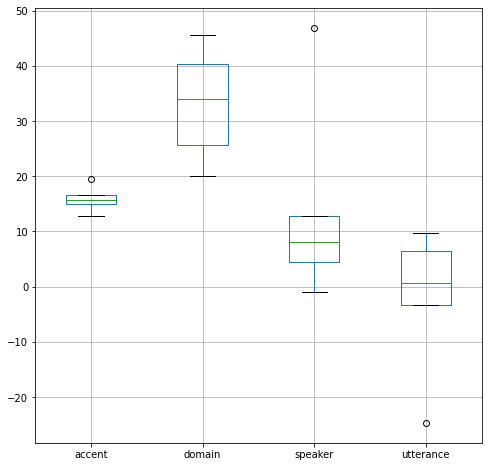

In [125]:
#need to get new dataframe, as df_1method has filtered accent and domain out
df_1method_all = df[(df.Method2 == '') & (df.Method3 == '')]
g_mode, agg_mode = aggregate_stats(df_1method_all, ['adapt_to'])
print (agg_mode.to_string())
plot_boxplot_from_stats(agg_mode, vert=True)

# public (yes) vs. proprietary datasets (no)


             werr   werr_std        min        max     median  low_perc  high_perc  n_points  n_studies  n_dsets
public                                                                                                          
no      14.575710  11.406102  -0.925926  46.900000  11.724613  6.717383  19.498516        50         10        7
yes      5.894939   7.024431 -24.725275  24.369748   5.882353  2.857143   9.160305        81         10        8


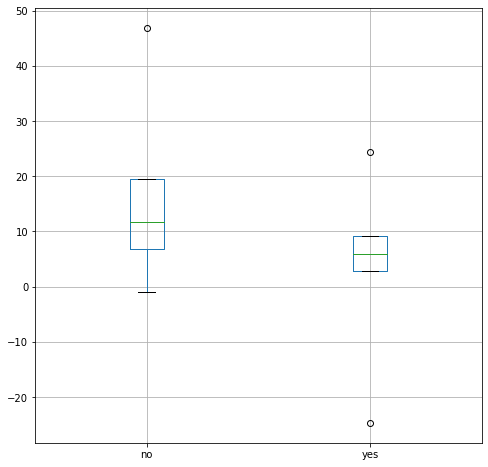

In [132]:
#note, here we use unfiltered data (i.e. also when more than one adaptation is stacked)
g_dset, agg_dset = aggregate_stats(df, ['public'])
print (agg_dset.to_string())
plot_boxplot_from_stats(agg_dset, vert=True)

# WERR across different datasets

                       werr   werr_std        min        max     median   low_perc  high_perc  n_points  n_studies  n_dsets
Train                                                                                                                      
AISHELL2           6.250000   2.946278   4.166667   8.333333   6.250000   5.208333   7.291667         2          1        1
AMI-IHM            5.832721   2.529116   1.140684   8.833922   6.642066   4.593640   7.420495        13          3        1
AMI-SDM            1.948393   1.140573   0.751880   3.777336   1.590457   1.060928   2.698612         7          2        1
Aurora4            3.636063  12.779359 -24.725275  24.369748   3.470437  -2.794394  11.804306        18          3        1
G-MobileSearch     5.823587   6.372268  -0.925926  15.204678   5.531189   0.462963   9.502924         6          1        1
Google-ALS        46.900000        NaN  46.900000  46.900000  46.900000  46.900000  46.900000         1          1        1
HKUST   

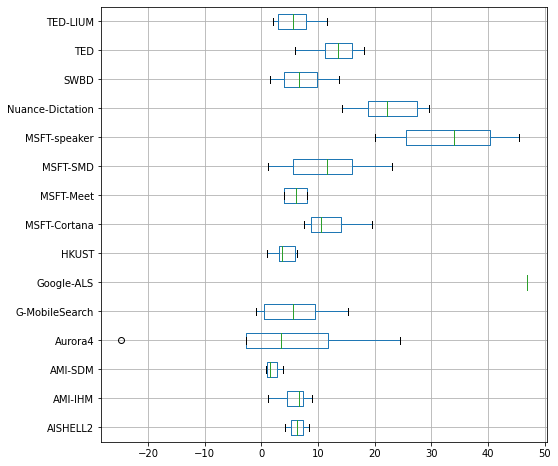

In [134]:
#note, here we use unfiltered data (i.e. also when more than one adaptation is stacked)
g_dset, agg_dset = aggregate_stats(df, ['Train'])
print (agg_dset.to_string())
plot_boxplot_from_stats(agg_dset, vert=False)

#finally, complimentarity. 

Note, here we somehwat need to better show that these are on top of existing ones already. This is perhaps not easy to do so in relative terms on independent plots. Need to draw stacked bar or so...

                       werr   werr_std        min        max     median   low_perc  high_perc  n_points  n_studies  n_dsets
Method1  Method2                                                                                                           
CFA               12.123249  10.792708   4.000000  24.369748   8.000000   6.000000  16.184874         3          2        2
         fMLLR     4.930869   1.906449   3.007519   7.224335   4.745811   3.584882   6.091798         4          1        2
CMN                4.593640        NaN   4.593640   4.593640   4.593640   4.593640   4.593640         1          1        1
CNNEmb            -2.631582  13.207147 -24.725275   7.506427  -0.274725  -3.084833   7.420495         5          2        2
DNNEmb            -4.683183  10.826888 -20.329670   3.393316  -0.898189  -7.665965   2.084593         4          1        1
Finetune          17.554315  12.042904   1.200000  46.900000  15.599284   8.477286  22.531481        35          9        6
LHT     

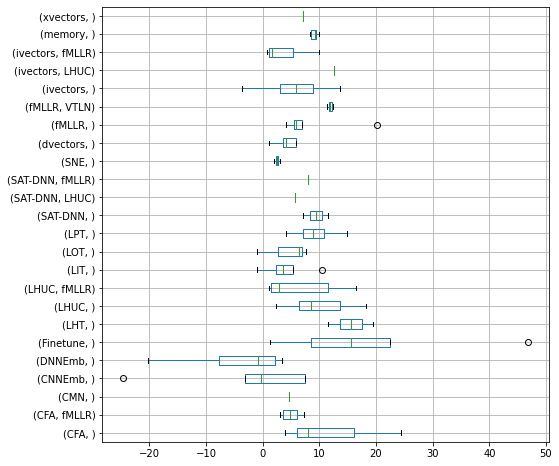

In [135]:
g_comp, agg_comp = aggregate_stats(df, ['Method1', 'Method2'])
print (agg_comp.to_string())
plot_boxplot_from_stats(agg_comp, vert=False)

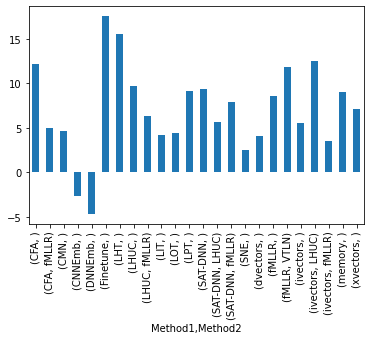

In [137]:
agg_comp.transpose().loc['werr'].plot.bar(stacked=True)